In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
data_august_missing = pd.read_parquet("../august_with_missing_order_days.parquet",engine='pyarrow')
df_august_missing = pd.DataFrame(data_august_missing)
df_august_missing['order_date'] = pd.to_datetime(df_august_missing['order_date'])
df_august_missing.info(),df_august_missing.describe(),df_august_missing.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317735 entries, 0 to 317734
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   account_id          317735 non-null  object        
 1   order_date          304297 non-null  datetime64[ns]
 2   transaction_amount  304297 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 7.3+ MB


(None,
        transaction_amount
 count       304297.000000
 mean           281.339536
 std           1251.632794
 min            -99.000000
 25%             34.930000
 50%             84.000000
 75%            205.250000
 max         171325.440000,
        account_id order_date  transaction_amount
 0  BR_09532176632 2022-08-03               11.16
 1  BR_09532176632 2022-08-03               32.52
 2  BR_09532176632 2022-08-03               24.90
 3  BR_09532176632 2022-08-03               28.50
 4  BR_09532176632 2022-08-03               11.16)

In [4]:
duplicated_rows = df_august_missing[df_august_missing.duplicated()]
duplicated_rows

,account_id,order_date,transaction_amount
4,BR_09532176632,2022-08-03,11.16
5,BR_09532176632,2022-08-03,11.16
6,BR_09532176632,2022-08-03,11.16
7,BR_09532176632,2022-08-03,24.90
9,BR_09532176632,2022-08-04,65.90
...,...,...,...
317541,BR_46809910204,2022-08-24,39.96
317587,BR_03565468000111,2022-08-10,22.44
317588,BR_03565468000111,2022-08-10,22.44
317695,BR_05314051000101,2022-08-11,20.76


Eyeballing the file, I see several rows missing data, as expected by the suggested problem

In [5]:

columns_with_missing_data = df_august_missing.columns[df_august_missing.isnull().any()]

columns_with_missing_data


Index(['order_date', 'transaction_amount'], dtype='object')

In [6]:
missing_order_date = df_august_missing['order_date'].isnull().sum()
missing_transaction_amount = df_august_missing['transaction_amount'].isnull().sum()

missing_order_date, missing_transaction_amount

(13438, 13438)

13438 rows are missing data from a total of 317735, it is ~4,23%. it is not too much....
The big problem here is that, is not one or another collumn is missing for a given user. For this ~5% user is missing both collumns.
I will filled this 13438 rows based on the previous values of each user. For the order date I am using a foward and backwarf fill and for the transaction I will use the mean for mean value for the transaction for a given user and if it is not available I will use the mean of the total distribution for all users.


In [7]:
####trying y filled the rows for date and transaction amount
#forward or backward fill 'order_date' based on each user's data
df_august_missing['order_date'] = df_august_missing.groupby('account_id')['order_date'].apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
#cheking out if some 'order_date' still missing after the fill
df_august_missing['order_date'] = df_august_missing['order_date'].fillna(df_august_missing['order_date'].mode()[0])  #if still missing, it applies the most common date as fallback

#filling the 'transaction_amount' using the mean from each user; otherwise will use mean distribution if no user-specific data is available
df_august_missing['transaction_amount'] = df_august_missing.groupby('account_id')['transaction_amount'].apply(lambda x: x.fillna(x.mean()))
global_mean = df_august_missing['transaction_amount'].mean()
df_august_missing['transaction_amount'] = df_august_missing['transaction_amount'].fillna(global_mean)

In [8]:
missing_order_date1 = df_august_missing['order_date'].isnull().sum()
missing_transaction_amount1 = df_august_missing['transaction_amount'].isnull().sum()

missing_order_date1, missing_transaction_amount1

(0, 0)

Now, there are not missing values, we can search now for duplicates and negative values

In [9]:
df_august_missing.to_csv("final_tablesv2/temp1.csv",index=False)

In [10]:
duplicate_count = df_august_missing.duplicated().sum()
negative_values_count = (df_august_missing['transaction_amount'] < 0).sum()
zero_values_count = (df_august_missing['transaction_amount'] == 0).sum()
duplicate_count, negative_values_count, zero_values_count

(26418, 233, 9506)

In [11]:
duplicated_rows1 = df_august_missing[df_august_missing.duplicated()]
duplicated_rows1

,account_id,order_date,transaction_amount
4,BR_09532176632,2022-08-03,11.16
5,BR_09532176632,2022-08-03,11.16
6,BR_09532176632,2022-08-03,11.16
7,BR_09532176632,2022-08-03,24.90
9,BR_09532176632,2022-08-04,65.90
...,...,...,...
317541,BR_46809910204,2022-08-24,39.96
317587,BR_03565468000111,2022-08-10,22.44
317588,BR_03565468000111,2022-08-10,22.44
317695,BR_05314051000101,2022-08-11,20.76


In [12]:
###removing the duplicates
df_august_missing_no_duplicates = df_august_missing.drop_duplicates(subset=['account_id', 'order_date', 'transaction_amount'], keep='first')
df_august_missing_no_duplicates['transaction_amount'] = df_august_missing_no_duplicates['transaction_amount'].round(2)
df_august_missing_no_duplicates.head(), df_august_missing_no_duplicates.info(), df_august_missing_no_duplicates.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291317 entries, 0 to 317734
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   account_id          291317 non-null  object        
 1   order_date          291317 non-null  datetime64[ns]
 2   transaction_amount  291317 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 8.9+ MB


/home/luidhy/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


(       account_id order_date  transaction_amount
 0  BR_09532176632 2022-08-03               11.16
 1  BR_09532176632 2022-08-03               32.52
 2  BR_09532176632 2022-08-03               24.90
 3  BR_09532176632 2022-08-03               28.50
 8  BR_09532176632 2022-08-04               65.90,
 None,
        transaction_amount
 count       291317.000000
 mean           289.107244
 std           1208.215925
 min            -99.000000
 25%             38.660000
 50%            103.800000
 75%            255.040000
 max         171325.440000)

In [13]:
###how many of this values are zero or negative?
negative_count_august_missing = df_august_missing_no_duplicates[df_august_missing_no_duplicates['transaction_amount'] < 0].shape[0]

print(f"Number of rows with negative o transaction amounts: {negative_count_august_missing}")

zero_count_august_missing = df_august_missing_no_duplicates[df_august_missing_no_duplicates['transaction_amount'] == 0].shape[0]

print(f"Number of rows with exactly zero transaction amounts: {zero_count_august_missing}")

Number of rows with negative o transaction amounts: 78
Number of rows with exactly zero transaction amounts: 7143


Think like I did for historical orders: fOr those transaction amount equals to zero, it means that any order was done in the day for a given user. On the other hand negative transaction makes sense only if some order was cancelled, however all the negative values are like -99, which means that there is not a clear registration for that user and transaction. Since the negative values represents less than 5% of the total  transaction sample, I will remove it from the dataset.

From here, I will create the same variables I create for the historical order, but the main predictions I will run using some predictive model and user the possible collumns calculet here as benchmark.

In [14]:
####removing the rows with negative values
df_cleaned_august_missing = df_august_missing_no_duplicates[df_august_missing_no_duplicates['transaction_amount'] >= 0]
df_cleaned_august_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291239 entries, 0 to 317734
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   account_id          291239 non-null  object        
 1   order_date          291239 non-null  datetime64[ns]
 2   transaction_amount  291239 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 8.9+ MB


the table above is the main table for august missing orders after performed the basic processing.

In [16]:
df_cleaned_august_missing['year'] = df_cleaned_august_missing['order_date'].dt.year
df_cleaned_august_missing['month'] = df_cleaned_august_missing['order_date'].dt.month
df_cleaned_august_missing['year_month'] = df_cleaned_august_missing['order_date'].dt.to_period('M')
df_cleaned_august_missing['day'] = df_cleaned_august_missing['order_date'].dt.day
df_cleaned_august_missing.head()


#sort the account id and date to get the right sequence
df_cleaned_august_missing = df_cleaned_august_missing.sort_values(by=['account_id', 'order_date'])

#this identify if the current row is a new order day (1 for new day, 0 for repeated day)
#checking if the current 'day' row is different from the previous row inside the account id
df_cleaned_august_missing['is_new_order_day'] = df_cleaned_august_missing.groupby(['account_id','year_month'])['day'].diff().ne(0).astype(int)

#calculation of the cumulative sum of new order days to track how many distinct days have had orders
df_cleaned_august_missing['cumulative_days_with_orders'] = df_cleaned_august_missing.groupby(['account_id','year_month'])['is_new_order_day'].cumsum()

In [60]:
df_cleaned_august_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291239 entries, 140541 to 316796
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   account_id                   291239 non-null  object        
 1   order_date                   291239 non-null  datetime64[ns]
 2   transaction_amount           291239 non-null  float64       
 3   year                         291239 non-null  int64         
 4   month                        291239 non-null  int64         
 5   year_month                   291239 non-null  period[M]     
 6   day                          291239 non-null  int64         
 7   is_new_order_day             291239 non-null  int64         
 8   cumulative_days_with_orders  291239 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1), period[M](1)
memory usage: 22.2+ MB


In [17]:
####saving the cleanded table just in case
df_cleaned_august_missing.to_parquet("final_tablesv2/august_with_missing_order_days_cleaned.parquet")



Obtaining the number with order days for the small table

In [20]:
filtered_orders_august_missing = df_cleaned_august_missing[df_cleaned_august_missing['transaction_amount'] > 0]
#separating the date into month/year of the order date and count the unique days with orders
filtered_orders_august_missing['year_month'] = filtered_orders_august_missing['order_date'].dt.to_period('M')
filtered_orders_august_missing['day'] = filtered_orders_august_missing['order_date'].dt.day
#grouping by account_id and year_month to count the number of unique days with orders
days_with_orders_august_missing = filtered_orders_august_missing.groupby(['account_id', 'year_month'])['day'].nunique().reset_index()


days_with_orders_august_missing = filtered_orders_august_missing.groupby(['account_id', 'year_month'])['day'].nunique().reset_index()
#days_with_orders_august_missing.head()
days_with_orders_august_missing = days_with_orders_august_missing.rename(columns={'day': 'number_of_days_with_orders'})
#days_with_orders_august_missing.info(),days_with_orders_august_missing.head()

df_cleaned_august_missing['order_date'] = pd.to_datetime(df_cleaned_august_missing['order_date'])
df_cleaned_august_missing['year_month'] = df_cleaned_august_missing['order_date'].dt.to_period('M')
df_cleaned_august_missing['day'] = df_cleaned_august_missing['order_date'].dt.day
#df_cleaned_august_missing.info()


###merger the dataframes to have more aggregate information from both tables
merged_df_august_missing_orders = pd.merge(df_cleaned_august_missing,days_with_orders_august_missing, on=['account_id', 'year_month'], how='left')
merged_df_august_missing_orders.head()




/home/luidhy/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,account_id,order_date,transaction_amount,year,month,year_month,day,is_new_order_day,cumulative_days_with_orders,number_of_days_with_orders
0,BR_00000343803,2022-08-02,281.34,2022,8,2022-08,2,1,1,1.0
1,BR_00001415930,2022-08-02,281.34,2022,8,2022-08,2,1,1,1.0
2,BR_00001760106,2022-08-02,281.34,2022,8,2022-08,2,1,1,1.0
3,BR_00002485176,2022-08-06,44.00,2022,8,2022-08,6,1,1,2.0
4,BR_00002485176,2022-08-13,44.00,2022,8,2022-08,13,1,2,2.0


In [22]:
###another sanity check
user_id = 'BR_09532176632'
month = 8
year = 2022
user_sanity_check1 = merged_df_august_missing_orders[(merged_df_august_missing_orders['account_id']== user_id) & 
                                                     (merged_df_august_missing_orders['month']==month) & 
                                                     (merged_df_august_missing_orders['year']==year)]
user_sanity_check1

,account_id,order_date,transaction_amount,year,month,year_month,day,is_new_order_day,cumulative_days_with_orders,number_of_days_with_orders
78155,BR_09532176632,2022-08-03,11.16,2022,8,2022-08,3,1,1,5.0
78156,BR_09532176632,2022-08-03,32.52,2022,8,2022-08,3,0,1,5.0
78157,BR_09532176632,2022-08-03,24.90,2022,8,2022-08,3,0,1,5.0
78158,BR_09532176632,2022-08-03,28.50,2022,8,2022-08,3,0,1,5.0
78159,BR_09532176632,2022-08-04,65.90,2022,8,2022-08,4,1,2,5.0
78160,BR_09532176632,2022-08-04,33.64,2022,8,2022-08,4,0,2,5.0
78161,BR_09532176632,2022-08-04,57.00,2022,8,2022-08,4,0,2,5.0
78162,BR_09532176632,2022-08-08,49.80,2022,8,2022-08,8,1,3,5.0
78163,BR_09532176632,2022-08-09,21.72,2022,8,2022-08,9,1,4,5.0
78164,BR_09532176632,2022-08-09,0.00,2022,8,2022-08,9,0,4,5.0


In [23]:
merged_df_august_missing_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291239 entries, 0 to 291238
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   account_id                   291239 non-null  object        
 1   order_date                   291239 non-null  datetime64[ns]
 2   transaction_amount           291239 non-null  float64       
 3   year                         291239 non-null  int64         
 4   month                        291239 non-null  int64         
 5   year_month                   291239 non-null  period[M]     
 6   day                          291239 non-null  int64         
 7   is_new_order_day             291239 non-null  int64         
 8   cumulative_days_with_orders  291239 non-null  int64         
 9   number_of_days_with_orders   291205 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(5), object(1), period[M](1)
memory usage: 24.4+ MB


creating an order summary table like I did for historical table

In [26]:
order_summary_august_missing_orders = merged_df_august_missing_orders.groupby(['account_id', 'order_date']).agg(
    total_number_orders_per_day=('transaction_amount', 'size'),  #count of orders 
    total_transaction_amount=('transaction_amount', 'sum')  #sum of transaction amounts
).reset_index()

order_summary_august_missing_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57340 entries, 0 to 57339
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   account_id                   57340 non-null  object        
 1   order_date                   57340 non-null  datetime64[ns]
 2   total_number_orders_per_day  57340 non-null  int64         
 3   total_transaction_amount     57340 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.8+ MB


In [27]:
user_date = '2022-08-03'
user_summary_august_missing_order = order_summary_august_missing_orders[(order_summary_august_missing_orders['account_id'] == user_id) & 
                                  (order_summary_august_missing_orders['order_date'] == user_date)]
print("This is the summary for user",user_id, "on order_summary table")
user_summary_august_missing_order

This is the summary for user BR_09532176632 on order_summary table


,account_id,order_date,total_number_orders_per_day,total_transaction_amount
15263,BR_09532176632,2022-08-03,4,97.08


In [47]:
###to get the day of the week
order_summary_august_missing_orders['day'] = order_summary_august_missing_orders['order_date'].dt.day
order_summary_august_missing_orders['day_of_week'] = order_summary_august_missing_orders['order_date'].dt.day_name()
order_summary_august_missing_orders.info(),order_summary_august_missing_orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57340 entries, 0 to 57339
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   account_id                   57340 non-null  object        
 1   order_date                   57340 non-null  datetime64[ns]
 2   total_number_orders_per_day  57340 non-null  int64         
 3   total_transaction_amount     57340 non-null  float64       
 4   day_of_week                  57340 non-null  object        
 5   month                        57340 non-null  int64         
 6   year                         57340 non-null  int64         
 7   day                          57340 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.5+ MB


(None,
        account_id order_date  total_number_orders_per_day  \
 0  BR_00000343803 2022-08-02                            1   
 1  BR_00001415930 2022-08-02                            1   
 2  BR_00001760106 2022-08-02                            1   
 3  BR_00002485176 2022-08-06                            1   
 4  BR_00002485176 2022-08-13                            6   
 
    total_transaction_amount day_of_week  month  year  day  
 0                    281.34     Tuesday      8  2022    2  
 1                    281.34     Tuesday      8  2022    2  
 2                    281.34     Tuesday      8  2022    2  
 3                     44.00    Saturday      8  2022    6  
 4                    283.98    Saturday      8  2022   13  )

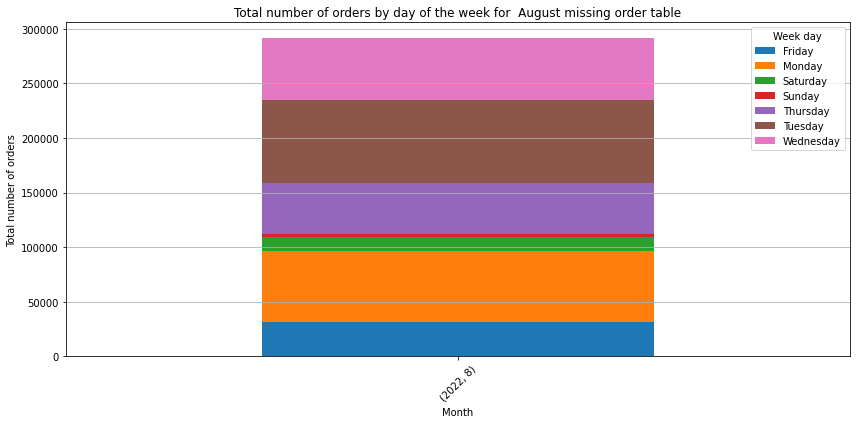

In [48]:
####lets check the number of orders ofr each day and month
order_summary_august_missing_orders['month'] = order_summary_august_missing_orders['order_date'].dt.month
order_summary_august_missing_orders['year'] = order_summary_august_missing_orders['order_date'].dt.year
####separating the data by year month and day
monthly_weekday_orders_august_missing_orders = order_summary_august_missing_orders.groupby(['year', 'month', 'day_of_week'])['total_number_orders_per_day'].sum().reset_index()
pivot_data = monthly_weekday_orders_august_missing_orders.pivot_table(index=['year', 'month'], columns='day_of_week', values='total_number_orders_per_day', fill_value=0)


pivot_data.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Total number of orders by day of the week for  August missing order table')
plt.xlabel('Month')
plt.ylabel('Total number of orders')
plt.xticks(rotation=45)
plt.legend(title='Week day')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [49]:
###to obtain the totalnumber 
monthly_weekday_orders_august_missing_orders = order_summary_august_missing_orders.groupby(['account_id', 'year', 'month'])['total_number_orders_per_day'].sum().reset_index(name='total_orders_per_month')


####to agregate this information to the order_summary information
order_summary_update_august_missing_orders = order_summary_august_missing_orders.merge(
    monthly_weekday_orders_august_missing_orders, 
    on=['account_id', 'year', 'month'], 
    how='left'
)

In [50]:
order_summary_update_august_missing_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57340 entries, 0 to 57339
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   account_id                   57340 non-null  object        
 1   order_date                   57340 non-null  datetime64[ns]
 2   total_number_orders_per_day  57340 non-null  int64         
 3   total_transaction_amount     57340 non-null  float64       
 4   day_of_week                  57340 non-null  object        
 5   month                        57340 non-null  int64         
 6   year                         57340 non-null  int64         
 7   day                          57340 non-null  int64         
 8   total_orders_per_month       57340 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 4.4+ MB


In [51]:
order_summary_update_august_missing_orders

,account_id,order_date,total_number_orders_per_day,total_transaction_amount,day_of_week,month,year,day,total_orders_per_month
0,BR_00000343803,2022-08-02,1,281.34,Tuesday,8,2022,2,1
1,BR_00001415930,2022-08-02,1,281.34,Tuesday,8,2022,2,1
2,BR_00001760106,2022-08-02,1,281.34,Tuesday,8,2022,2,1
3,BR_00002485176,2022-08-06,1,44.00,Saturday,8,2022,6,7
4,BR_00002485176,2022-08-13,6,283.98,Saturday,8,2022,13,7
...,...,...,...,...,...,...,...,...,...
57335,BR_99904403791,2022-08-02,1,281.34,Tuesday,8,2022,2,1
57336,BR_99910241587,2022-08-02,1,281.34,Tuesday,8,2022,2,1
57337,BR_99936259300,2022-08-01,2,179.80,Monday,8,2022,1,2
57338,BR_99946866587,2022-08-02,1,281.34,Tuesday,8,2022,2,1


In [52]:
####lets create two more variables to addres  the amount of orders and transactions accumulate for each user.
order_summary_update_august_missing_orders['cumulative_number_of_orders'] = order_summary_update_august_missing_orders.groupby(['account_id', 'year', 'month'])['total_number_orders_per_day'].cumsum()
order_summary_update_august_missing_orders['cumulative_transaction_amount'] = order_summary_update_august_missing_orders.groupby(['account_id', 'year', 'month'])['total_transaction_amount'].cumsum()


In [53]:
order_summary_update_august_missing_orders

,account_id,order_date,total_number_orders_per_day,total_transaction_amount,day_of_week,month,year,day,total_orders_per_month,cumulative_number_of_orders,cumulative_transaction_amount
0,BR_00000343803,2022-08-02,1,281.34,Tuesday,8,2022,2,1,1,281.34
1,BR_00001415930,2022-08-02,1,281.34,Tuesday,8,2022,2,1,1,281.34
2,BR_00001760106,2022-08-02,1,281.34,Tuesday,8,2022,2,1,1,281.34
3,BR_00002485176,2022-08-06,1,44.00,Saturday,8,2022,6,7,1,44.00
4,BR_00002485176,2022-08-13,6,283.98,Saturday,8,2022,13,7,7,327.98
...,...,...,...,...,...,...,...,...,...,...,...
57335,BR_99904403791,2022-08-02,1,281.34,Tuesday,8,2022,2,1,1,281.34
57336,BR_99910241587,2022-08-02,1,281.34,Tuesday,8,2022,2,1,1,281.34
57337,BR_99936259300,2022-08-01,2,179.80,Monday,8,2022,1,2,2,179.80
57338,BR_99946866587,2022-08-02,1,281.34,Tuesday,8,2022,2,1,1,281.34


In [54]:
######calculation for the remaining_number_of_orders
order_summary_update_august_missing_orders['remaining_number_of_orders'] = order_summary_update_august_missing_orders['total_orders_per_month'] - order_summary_update_august_missing_orders['cumulative_number_of_orders']
order_summary_update_august_missing_orders.head()

,account_id,order_date,total_number_orders_per_day,total_transaction_amount,day_of_week,month,year,day,total_orders_per_month,cumulative_number_of_orders,cumulative_transaction_amount,remaining_number_of_orders
0,BR_00000343803,2022-08-02,1,281.34,Tuesday,8,2022,2,1,1,281.34,0
1,BR_00001415930,2022-08-02,1,281.34,Tuesday,8,2022,2,1,1,281.34,0
2,BR_00001760106,2022-08-02,1,281.34,Tuesday,8,2022,2,1,1,281.34,0
3,BR_00002485176,2022-08-06,1,44.00,Saturday,8,2022,6,7,1,44.00,6
4,BR_00002485176,2022-08-13,6,283.98,Saturday,8,2022,13,7,7,327.98,0


In [55]:
order_summary_update_august_missing_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57340 entries, 0 to 57339
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   account_id                     57340 non-null  object        
 1   order_date                     57340 non-null  datetime64[ns]
 2   total_number_orders_per_day    57340 non-null  int64         
 3   total_transaction_amount       57340 non-null  float64       
 4   day_of_week                    57340 non-null  object        
 5   month                          57340 non-null  int64         
 6   year                           57340 non-null  int64         
 7   day                            57340 non-null  int64         
 8   total_orders_per_month         57340 non-null  int64         
 9   cumulative_number_of_orders    57340 non-null  int64         
 10  cumulative_transaction_amount  57340 non-null  float64       
 11  remaining_numbe

In [56]:
####calculation for the remaining__number_of_with_orders
#merged_df = merged_df.drop('remaining__number_of_with_orders', axis=1)
merged_df_august_missing_orders['remaining__number_of_days_with_orders'] = merged_df_august_missing_orders['number_of_days_with_orders'] - merged_df_august_missing_orders['cumulative_days_with_orders']
merged_df_august_missing_orders.head()

,account_id,order_date,transaction_amount,year,month,year_month,day,is_new_order_day,cumulative_days_with_orders,number_of_days_with_orders,remaining__number_of_days_with_orders
0,BR_00000343803,2022-08-02,281.34,2022,8,2022-08,2,1,1,1.0,0.0
1,BR_00001415930,2022-08-02,281.34,2022,8,2022-08,2,1,1,1.0,0.0
2,BR_00001760106,2022-08-02,281.34,2022,8,2022-08,2,1,1,1.0,0.0
3,BR_00002485176,2022-08-06,44.00,2022,8,2022-08,6,1,1,2.0,1.0
4,BR_00002485176,2022-08-13,44.00,2022,8,2022-08,13,1,2,2.0,0.0


In [57]:
merged_df_august_missing_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291239 entries, 0 to 291238
Data columns (total 11 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   account_id                             291239 non-null  object        
 1   order_date                             291239 non-null  datetime64[ns]
 2   transaction_amount                     291239 non-null  float64       
 3   year                                   291239 non-null  int64         
 4   month                                  291239 non-null  int64         
 5   year_month                             291239 non-null  period[M]     
 6   day                                    291239 non-null  int64         
 7   is_new_order_day                       291239 non-null  int64         
 8   cumulative_days_with_orders            291239 non-null  int64         
 9   number_of_days_with_orders             291205 no

In [58]:
usuario = 'BR_11483853713'
mes = 8
ano = 2022
check_usuario1 = merged_df_august_missing_orders[(merged_df_august_missing_orders['account_id'] == usuario) & 
                                                (merged_df_august_missing_orders['month'] == mes) & 
                                                (merged_df_august_missing_orders['year'] ==ano)]
check_usuario1

,account_id,order_date,transaction_amount,year,month,year_month,day,is_new_order_day,cumulative_days_with_orders,number_of_days_with_orders,remaining__number_of_days_with_orders
89758,BR_11483853713,2022-08-02,119.12,2022,8,2022-08,2,1,1,5.0,4.0
89759,BR_11483853713,2022-08-02,429.74,2022,8,2022-08,2,0,1,5.0,4.0
89760,BR_11483853713,2022-08-02,564.98,2022,8,2022-08,2,0,1,5.0,4.0
89761,BR_11483853713,2022-08-02,563.90,2022,8,2022-08,2,0,1,5.0,4.0
89762,BR_11483853713,2022-08-02,163.93,2022,8,2022-08,2,0,1,5.0,4.0
89763,BR_11483853713,2022-08-06,286.80,2022,8,2022-08,6,1,2,5.0,3.0
89764,BR_11483853713,2022-08-06,482.37,2022,8,2022-08,6,0,2,5.0,3.0
89765,BR_11483853713,2022-08-06,446.58,2022,8,2022-08,6,0,2,5.0,3.0
89766,BR_11483853713,2022-08-06,738.48,2022,8,2022-08,6,0,2,5.0,3.0
89767,BR_11483853713,2022-08-06,644.62,2022,8,2022-08,6,0,2,5.0,3.0


In [59]:
check_usuario_summary1 = order_summary_update_august_missing_orders[(order_summary_update_august_missing_orders['account_id'] == usuario) 
                                                                    & (order_summary_update_august_missing_orders['month'] == mes) & 
                                                                    (order_summary_update_august_missing_orders['year'] ==ano)]
check_usuario_summary1

,account_id,order_date,total_number_orders_per_day,total_transaction_amount,day_of_week,month,year,day,total_orders_per_month,cumulative_number_of_orders,cumulative_transaction_amount,remaining_number_of_orders
17439,BR_11483853713,2022-08-02,5,1841.67,Tuesday,8,2022,2,30,5,1841.67,25
17440,BR_11483853713,2022-08-06,7,2716.02,Saturday,8,2022,6,30,12,4557.69,18
17441,BR_11483853713,2022-08-10,6,1545.66,Wednesday,8,2022,10,30,18,6103.35,12
17442,BR_11483853713,2022-08-16,10,2813.79,Tuesday,8,2022,16,30,28,8917.14,2
17443,BR_11483853713,2022-08-24,2,666.28,Wednesday,8,2022,24,30,30,9583.42,0


In [60]:
###lets perform an one hot encoding for the variable days of the week
order_summary_encoded_august_missing_orders = pd.get_dummies(order_summary_update_august_missing_orders, columns=['day_of_week'])
order_summary_encoded_august_missing_orders.head()

,account_id,order_date,total_number_orders_per_day,total_transaction_amount,month,year,day,total_orders_per_month,cumulative_number_of_orders,cumulative_transaction_amount,remaining_number_of_orders,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,BR_00000343803,2022-08-02,1,281.34,8,2022,2,1,1,281.34,0,0,0,0,0,0,1,0
1,BR_00001415930,2022-08-02,1,281.34,8,2022,2,1,1,281.34,0,0,0,0,0,0,1,0
2,BR_00001760106,2022-08-02,1,281.34,8,2022,2,1,1,281.34,0,0,0,0,0,0,1,0
3,BR_00002485176,2022-08-06,1,44.00,8,2022,6,7,1,44.00,6,0,0,1,0,0,0,0
4,BR_00002485176,2022-08-13,6,283.98,8,2022,13,7,7,327.98,0,0,0,1,0,0,0,0


In [61]:
merged_df_august_missing_orders.to_parquet("final_tablesv2/august_with_missing_order_days_cleaned_mergeddf.parquet",index=False)
order_summary_update_august_missing_orders.to_parquet("final_tablesv2/august_with_missing_order_days_cleaned_order_summary_updated.parquet",index=False)
order_summary_encoded_august_missing_orders.to_parquet("final_tablesv2/august_with_missing_order_days_cleaned_order_summary_encoded.parquet",index=False)

In [62]:
######merging the tables 
merged_df_august_missing_orders.info(),


<class 'pandas.core.frame.DataFrame'>
Int64Index: 291239 entries, 0 to 291238
Data columns (total 11 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   account_id                             291239 non-null  object        
 1   order_date                             291239 non-null  datetime64[ns]
 2   transaction_amount                     291239 non-null  float64       
 3   year                                   291239 non-null  int64         
 4   month                                  291239 non-null  int64         
 5   year_month                             291239 non-null  period[M]     
 6   day                                    291239 non-null  int64         
 7   is_new_order_day                       291239 non-null  int64         
 8   cumulative_days_with_orders            291239 non-null  int64         
 9   number_of_days_with_orders             291205 no

(None,)

In [63]:
order_summary_encoded_august_missing_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57340 entries, 0 to 57339
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   account_id                     57340 non-null  object        
 1   order_date                     57340 non-null  datetime64[ns]
 2   total_number_orders_per_day    57340 non-null  int64         
 3   total_transaction_amount       57340 non-null  float64       
 4   month                          57340 non-null  int64         
 5   year                           57340 non-null  int64         
 6   day                            57340 non-null  int64         
 7   total_orders_per_month         57340 non-null  int64         
 8   cumulative_number_of_orders    57340 non-null  int64         
 9   cumulative_transaction_amount  57340 non-null  float64       
 10  remaining_number_of_orders     57340 non-null  int64         
 11  day_of_week_Fri

In [65]:
column_names = ['account_id', 'order_date', 'year', 'month', 'day']
master_table_august_missing_orders = pd.merge(merged_df_august_missing_orders,order_summary_encoded_august_missing_orders,on=column_names,how='inner')

In [68]:
master_table_august_missing_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291239 entries, 0 to 291238
Data columns (total 24 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   account_id                             291239 non-null  object        
 1   order_date                             291239 non-null  datetime64[ns]
 2   transaction_amount                     291239 non-null  float64       
 3   year                                   291239 non-null  int64         
 4   month                                  291239 non-null  int64         
 5   year_month                             291239 non-null  period[M]     
 6   day                                    291239 non-null  int64         
 7   is_new_order_day                       291239 non-null  int64         
 8   cumulative_days_with_orders            291239 non-null  int64         
 9   number_of_days_with_orders             291205 no

In [69]:
master_table_august_missing_orders.to_parquet("final_tablesv2/master_table_august_missing_orders.parquet",index=False)
